In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
INPUT_FILE = "test2025.csv"                   # CSV with idCredito, amount, fechaEnvio, idBanco
METRICS_FILE = "data/output/credit_repayment_metrics.csv"     # CSV with idCredito, repayment_ratio
OUTPUT_FILE = "repayment_simulation_test_1.csv" #idCredito, amount, fechaEnvio, idEmisora, idBanco, cost 

In [6]:
input_df = pd.read_csv(INPUT_FILE)

In [7]:
input_df["idCredito"] = input_df["idCredito"].astype(str)


In [12]:
metrics_df = pd.read_csv(METRICS_FILE)
metrics_df["idCredito"] = metrics_df["idCredito"].astype(str)

In [13]:
merged = pd.merge(input_df, metrics_df[["idCredito", "repayment_ratio"]], on="idCredito", how="left")


In [15]:
merged["expected_repayment"] = merged["montoExigible"] * merged["repayment_ratio"]


In [16]:
def seasonality_score(day):
    # Peaks on day 1, 15, 30 (3 cycles in a month)
    radians = (day / 30) * 2 * np.pi * 3
    return (np.cos(radians) + 1) / 2

In [18]:
if "fechaEnvioCobro" in input_df.columns:
    merged["fechaEnvioCobro"] = pd.to_datetime(merged["fechaEnvioCobro"], errors='coerce', dayfirst=True)
    merged["day_of_month"] = merged["fechaEnvioCobro"].dt.day
    merged["seasonality_score"] = merged["day_of_month"].apply(lambda d: seasonality_score(d) if not pd.isna(d) else np.nan)
else:
    merged["seasonality_score"] = np.nan

In [19]:
merged["adjusted_expected_repayment"] = merged["expected_repayment"] * merged["seasonality_score"]


In [20]:
merged.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Results saved to {OUTPUT_FILE}")
print(merged.head(10))

✅ Results saved to repayment_simulation_output.csv
  idCredito  montoExigible fechaEnvioCobro  idBanco  repayment_ratio  \
0    104310         581.24      2025-10-04       72         0.052632   
1    104310         581.24             NaT       72         0.052632   
2    104310         581.24      2025-12-05       72         0.052632   
3     10983        2006.34      2025-10-01       72         0.400000   
4     10983        2006.34             NaT       72         0.400000   
5     10983        2006.34      2025-11-02       72         0.400000   
6    110593         490.49      2025-10-01       12         0.000049   
7    110593         490.49             NaT       12         0.000049   
8    110593         490.49             NaT       12         0.000049   
9    110593         490.49             NaT       12         0.000049   

   expected_repayment  seasonality_score  day_of_month  \
0           30.591579           0.095492           4.0   
1           30.591579                NaN

/var/folders/kx/jlpqh21n7k507vqh88ns0shm0000gn/T/ipykernel_27747/1150715436.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/credf/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


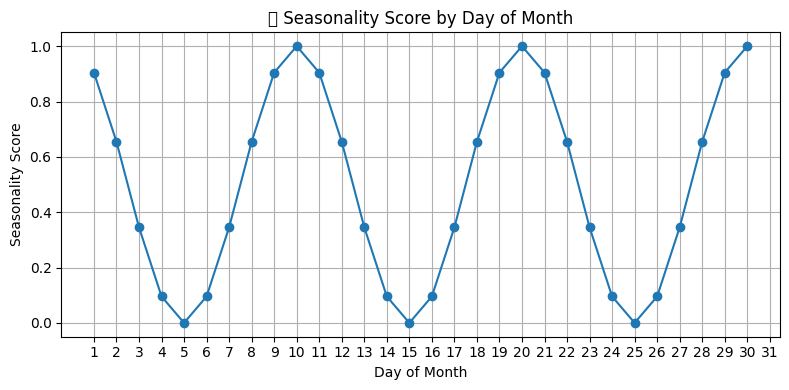

In [21]:

days = np.arange(1, 31)
scores = [seasonality_score(d) for d in days]

plt.figure(figsize=(8, 4))
plt.plot(days, scores, marker='o')
plt.title("📈 Seasonality Score by Day of Month")
plt.xlabel("Day of Month")
plt.ylabel("Seasonality Score")
plt.grid(True)
plt.xticks(range(1, 32))
plt.tight_layout()
plt.show()

In [ ]:
def classify_risk(ratio):
    if pd.isna(ratio):
        return "unknown"
    return "highrisk" if ratio < 0.5 else "lowrisk"

merged["risk_level"] = merged["repayment_ratio"].apply(classify_risk)


In [ ]:

strategy_df = pd.read_csv("strategies.csv")
